# KAMA cross - Strategy - Backtesting 

### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [6]:
def cal_signal(r):
    signal = ''
    if r['Close_s1'] < r['KAMA_s1'] and r['Close'] > r['KAMA']:
        signal = 'long'
    elif r['Close_s1'] > r['KAMA_s1'] and r['Close'] < r['KAMA']:
        signal = 'short'
    return signal

def prepare_data(df):
    df['KAMA'] = ta.kama(df['Close'], length=10)
    df['KAMA_s1'] = df['KAMA'].shift(1)
    df['Close_s1'] = df['Close'].shift(1)
    df['signal'] = df.apply(lambda r: cal_signal(r), axis=1)
    df["ATR"] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    return df

In [7]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [8]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        atr = self.data.ATR[-1]
        if atr > 3:
            return
        if signal == 'long':
            buy_price = close_price
            sl = buy_price - atr * 1.5
            tp = buy_price + self.reward_on_risk * atr * 2.5
            self.buy(size=1, sl=sl, tp=tp)
            # self.buy(size=1, sl=sl, tp=tp, limit=buy_price)
        elif signal == 'short':
            sell_price = close_price
            sl = sell_price + atr * 1.5
            tp = sell_price - self.reward_on_risk * atr * 2.5
            self.sell(size=1, sl=sl, tp=tp)
            # self.sell(size=1, sl=sl, tp=tp, limit=sell_price)

In [9]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [10]:
stats

Start                     2020-11-02 10:10:00
End                       2025-02-25 14:45:00
Duration                   1576 days 04:35:00
Exposure Time [%]                   49.107159
Equity Final [$]                  2296.589335
Equity Peak [$]                   2300.389335
Return [%]                          53.105956
Buy & Hold Return [%]               51.139269
Return (Ann.) [%]                   10.490588
Volatility (Ann.) [%]                6.921829
Sharpe Ratio                          1.51558
Sortino Ratio                         2.88216
Calmar Ratio                         1.610582
Max. Drawdown [%]                   -6.513539
Avg. Drawdown [%]                   -0.284424
Max. Drawdown Duration      385 days 02:25:00
Avg. Drawdown Duration        4 days 01:19:00
# Trades                                 1753
Win Rate [%]                        33.827724
Best Trade [%]                       2.207692
Worst Trade [%]                     -0.472129
Avg. Trade [%]                    

In [11]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,117,124,911.92634,913.846254,-1.919914,-0.002105,2020-11-04 11:25:00,2020-11-04 13:25:00,None,0 days 02:00:00
1,-1,130,130,912.52616,914.431716,-1.905556,-0.002088,2020-11-04 13:55:00,2020-11-04 13:55:00,None,0 days 00:00:00
2,1,131,135,916.87498,914.188398,-2.686582,-0.002930,2020-11-04 14:00:00,2020-11-04 14:20:00,None,0 days 00:20:00
3,-1,136,137,912.22625,913.500000,-1.273750,-0.001396,2020-11-04 14:25:00,2020-11-04 14:30:00,None,0 days 00:05:00
4,1,147,187,914.27420,912.281964,-1.992236,-0.002179,2020-11-05 09:40:00,2020-11-05 14:25:00,None,0 days 04:45:00
...,...,...,...,...,...,...,...,...,...,...,...
1748,-1,54673,54674,1345.59620,1348.295499,-2.699299,-0.002006,2025-02-21 09:05:00,2025-02-21 09:10:00,None,0 days 00:05:00
1749,1,54677,54721,1350.00488,1351.400000,1.395120,0.001033,2025-02-21 09:25:00,2025-02-21 14:30:00,None,0 days 05:05:00
1750,-1,54724,54725,1351.69437,1354.471603,-2.777233,-0.002055,2025-02-24 09:05:00,2025-02-24 09:10:00,None,0 days 00:05:00
1751,1,54726,54771,1354.20614,1366.262521,12.056381,0.008903,2025-02-24 09:15:00,2025-02-24 14:25:00,None,0 days 05:10:00


In [12]:
# bt.plot()

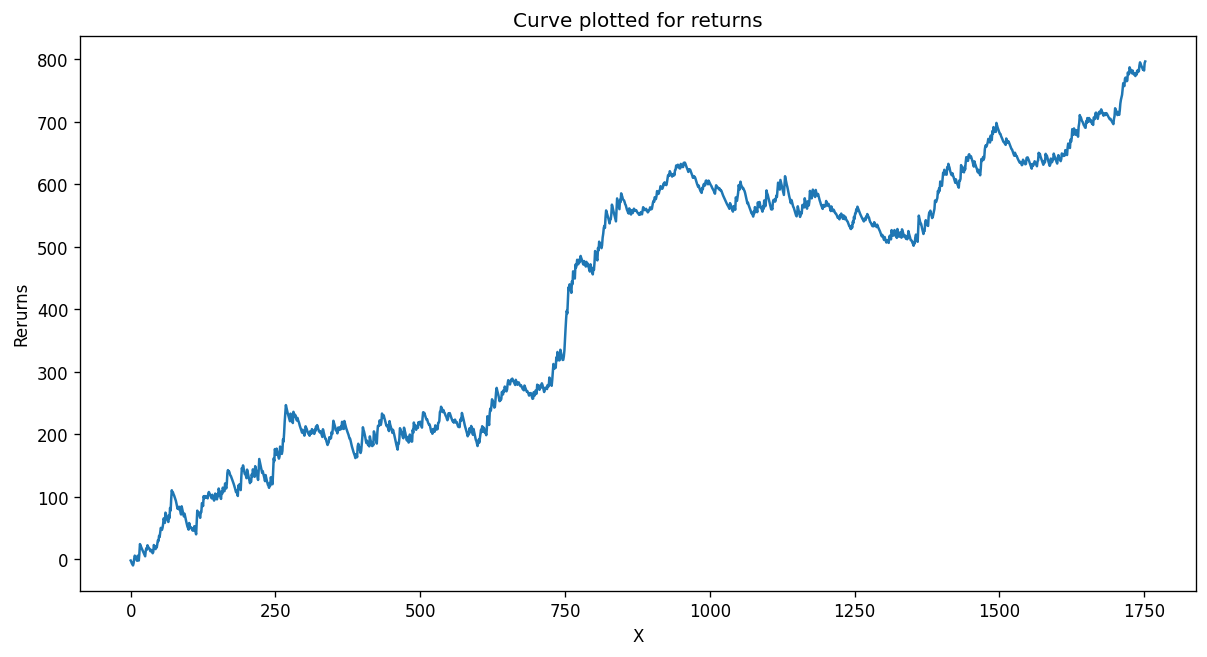

In [13]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [14]:
copy_trades['PnL'].min()

-5.464673128666618

In [15]:
copy_trades[copy_trades.PnL < -28]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration,cum_sum


In [16]:
prepared_data['ATR'].max()

11.687843261910594